In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

In [3]:
df = pd.read_csv('../data/processed/cleaned.csv')

In [4]:
df.shape

(776686, 8)

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Date'] = df['InvoiceDate'].dt.date
daily_sales = df.groupby(['Date', 'StockCode'])['Quantity'].sum().reset_index()

In [6]:
daily_sales.head(5)

,Date,StockCode,Quantity
0,2009-12-01,10002,12
1,2009-12-01,10120,60
2,2009-12-01,10125,4
3,2009-12-01,10133,6
4,2009-12-01,10135,17


In [7]:
ts_data = daily_sales.pivot(index='Date', columns='StockCode', values='Quantity').fillna(0)
ts_data.index = pd.to_datetime(ts_data.index) 
ts_data

StockCode,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,90214U,90214V,90214W,90214Y,90214Z,ADJUST,ADJUST2,SP1002,TEST001,TEST002
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,12.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,4.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-12-02,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-12-03,6.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-12-04,73.0,3.0,0.0,30.0,1.0,0.0,0.0,0.0,46.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-12-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,12.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0
2011-12-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-12-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_long = ts_data.stack().reset_index()
df_long.columns = ['Date', 'StockCode', 'Sales']

In [9]:
df_long

,Date,StockCode,Sales
0,2009-12-01,10002,12.0
1,2009-12-01,10080,0.0
2,2009-12-01,10109,0.0
3,2009-12-01,10120,60.0
4,2009-12-01,10123C,0.0
...,...,...,...
2792891,2011-12-09,ADJUST,0.0
2792892,2011-12-09,ADJUST2,0.0
2792893,2011-12-09,SP1002,0.0
2792894,2011-12-09,TEST001,0.0


In [10]:
def create_features_all(df):
    df = df.sort_values(['StockCode', 'Date'])
    
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    
    for lag in [7,14,30]:
        df[f'lag_{lag}'] = df.groupby('StockCode')['Sales'].shift(lag)

    df['rolling_7'] = df.groupby('StockCode')['Sales'].shift(1).rolling(7).mean()
    df['rolling_14'] = df.groupby('StockCode')['Sales'].shift(1).rolling(14).mean()

    return df.dropna()


In [11]:
df_features = create_features_all(df_long)
df_features

,Date,StockCode,Sales,DayOfWeek,Month,lag_7,lag_14,lag_30,rolling_7,rolling_14
138720,2010-01-14,10002,140.0,3,1,0.0,0.0,12.0,8.571429,5.428571
143344,2010-01-15,10002,0.0,4,1,0.0,0.0,0.0,28.571429,15.428571
147968,2010-01-17,10002,3.0,6,1,12.0,12.0,6.0,28.571429,15.428571
152592,2010-01-18,10002,0.0,0,1,0.0,0.0,73.0,27.285714,14.785714
157216,2010-01-19,10002,0.0,1,1,48.0,1.0,0.0,27.285714,14.785714
...,...,...,...,...,...,...,...,...,...,...
2774399,2011-12-05,TEST002,0.0,0,12,0.0,0.0,0.0,0.000000,0.000000
2779023,2011-12-06,TEST002,0.0,1,12,0.0,0.0,0.0,0.000000,0.000000
2783647,2011-12-07,TEST002,0.0,2,12,0.0,0.0,0.0,0.000000,0.000000
2788271,2011-12-08,TEST002,0.0,3,12,0.0,0.0,0.0,0.000000,0.000000


In [12]:
product_mean = df_long.groupby('StockCode')['Sales'].mean()
df_features['product_mean'] = df_features['StockCode'].map(product_mean)
df_features['is_zero_lag7'] = (df_features['lag_7'] == 0).astype(int)
df_features['is_zero_lag14'] = (df_features['lag_14'] == 0).astype(int)
df_features

,Date,StockCode,Sales,DayOfWeek,Month,lag_7,lag_14,lag_30,rolling_7,rolling_14,product_mean,is_zero_lag7,is_zero_lag14
138720,2010-01-14,10002,140.0,3,1,0.0,0.0,12.0,8.571429,5.428571,14.038079,1,1
143344,2010-01-15,10002,0.0,4,1,0.0,0.0,0.0,28.571429,15.428571,14.038079,1,1
147968,2010-01-17,10002,3.0,6,1,12.0,12.0,6.0,28.571429,15.428571,14.038079,0,0
152592,2010-01-18,10002,0.0,0,1,0.0,0.0,73.0,27.285714,14.785714,14.038079,1,1
157216,2010-01-19,10002,0.0,1,1,48.0,1.0,0.0,27.285714,14.785714,14.038079,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2774399,2011-12-05,TEST002,0.0,0,12,0.0,0.0,0.0,0.000000,0.000000,0.001656,1,1
2779023,2011-12-06,TEST002,0.0,1,12,0.0,0.0,0.0,0.000000,0.000000,0.001656,1,1
2783647,2011-12-07,TEST002,0.0,2,12,0.0,0.0,0.0,0.000000,0.000000,0.001656,1,1
2788271,2011-12-08,TEST002,0.0,3,12,0.0,0.0,0.0,0.000000,0.000000,0.001656,1,1


In [13]:
def create_advanced_features(df):
    df = df.sort_values(['StockCode', 'Date'])
    
    # --- Cyclical Encoding ---
    # Treats Sunday (6) and Monday (0) as neighbors in a circle
    df['day_sin'] = np.sin(2 * np.pi * df['Date'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['Date'].dt.dayofweek / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)
    
    # --- Rolling Volatility ---
    # Captures how 'erratic' or 'stable' a product is
    df['rolling_std_7'] = df.groupby('StockCode')['Sales'].shift(1).rolling(7).std()
    
    # --- Existing Features ---
    for lag in [7, 14, 30]:
        df[f'lag_{lag}'] = df.groupby('StockCode')['Sales'].shift(lag)
    
    df['rolling_7'] = df.groupby('StockCode')['Sales'].shift(1).rolling(7).mean()
    df['product_mean'] = df.groupby('StockCode')['Sales'].transform('mean')
    
    return df.dropna()

In [14]:
df_features = create_advanced_features(df_features)

In [15]:
df_features['Sales_Log'] = np.log1p(df_features['Sales'])

In [16]:
df_features.sample(5)

,Date,StockCode,Sales,DayOfWeek,Month,lag_7,lag_14,lag_30,rolling_7,rolling_14,product_mean,is_zero_lag7,is_zero_lag14,day_sin,day_cos,month_sin,month_cos,rolling_std_7,Sales_Log
1471086,2010-12-23,21277,0.0,3,12,0.0,0.0,0.0,0.000000,0.000000,0.074913,1,1,0.433884,-0.900969,-2.449294e-16,1.000000,0.000000,0.0
1504495,2011-01-11,22515,0.0,1,1,0.0,0.0,0.0,5.428571,3.142857,1.724739,1,1,0.781831,0.623490,5.000000e-01,0.866025,13.501323,0.0
1295498,2010-11-09,21418,0.0,1,11,0.0,0.0,0.0,0.000000,0.000000,0.259582,1,1,0.781831,0.623490,-5.000000e-01,0.866025,0.000000,0.0
873311,2010-07-23,85039B,0.0,4,7,0.0,0.0,0.0,1.142857,0.714286,2.088850,1,1,-0.433884,-0.900969,-5.000000e-01,-0.866025,2.035401,0.0
2756450,2011-12-01,21143,0.0,3,12,0.0,0.0,0.0,0.000000,0.000000,3.198606,1,1,0.433884,-0.900969,-2.449294e-16,1.000000,0.000000,0.0


In [17]:
cutoff = df_features['Date'].max() - pd.Timedelta(days=120)

train = df_features[df_features['Date'] <= cutoff]
test = df_features[df_features['Date'] > cutoff]

In [18]:
test.sample(5)

,Date,StockCode,Sales,DayOfWeek,Month,lag_7,lag_14,lag_30,rolling_7,rolling_14,product_mean,is_zero_lag7,is_zero_lag14,day_sin,day_cos,month_sin,month_cos,rolling_std_7,Sales_Log
2726488,2011-11-23,37494A,0.0,2,11,0.0,0.0,0.0,0.000000,0.000000,0.137631,1,1,0.974928,-0.222521,-0.500000,8.660254e-01,0.000000,0.000000
2680613,2011-11-11,79303D,0.0,4,11,0.0,0.0,0.0,0.000000,0.000000,0.076655,1,1,-0.433884,-0.900969,-0.500000,8.660254e-01,0.000000,0.000000
2457582,2011-09-16,23076,0.0,4,9,48.0,0.0,0.0,24.000000,24.000000,13.756098,0,1,-0.433884,-0.900969,-1.000000,-1.836970e-16,19.595918,0.000000
2608912,2011-10-25,21671,24.0,1,10,0.0,3.0,24.0,0.857143,5.857143,14.712544,1,0,0.781831,0.623490,-0.866025,5.000000e-01,2.267787,3.218876
2742033,2011-11-28,10080,0.0,0,11,0.0,24.0,0.0,3.857143,4.785714,0.520906,1,0,0.000000,1.000000,-0.500000,8.660254e-01,10.205041,0.000000


In [19]:
X_train = train.drop(['Sales', 'Sales_Log', 'Date', 'StockCode'], axis=1)
y_train = train['Sales_Log']

X_test = test.drop(['Sales', 'Sales_Log', 'Date', 'StockCode'], axis=1)
y_test = test['Sales']

In [20]:
# Baseline Model using 7 day rolling mean as prediction for comparison
baseline_preds = test['lag_7']
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
baseline_rmse
baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_mae

6.607230392156863

In [21]:
# XGBoost Model
model_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03, 
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
preds_log = model_xgb.predict(X_test)
xgb_preds = np.expm1(preds_log)

Baseline RMSE: 126.45
XGBoost RMSE: 122.62
-----
Baseline MAE: 6.61
XGBoost MAE: 4.47


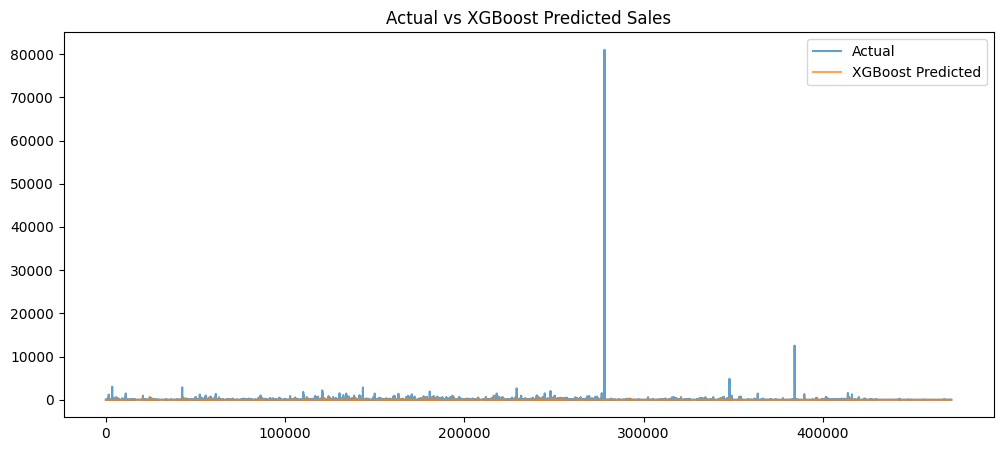

In [22]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)

print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

print("-----")

print(f"Baseline MAE: {baseline_mae:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")

# Plot Actual vs Predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(xgb_preds, label='XGBoost Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs XGBoost Predicted Sales')
plt.show()

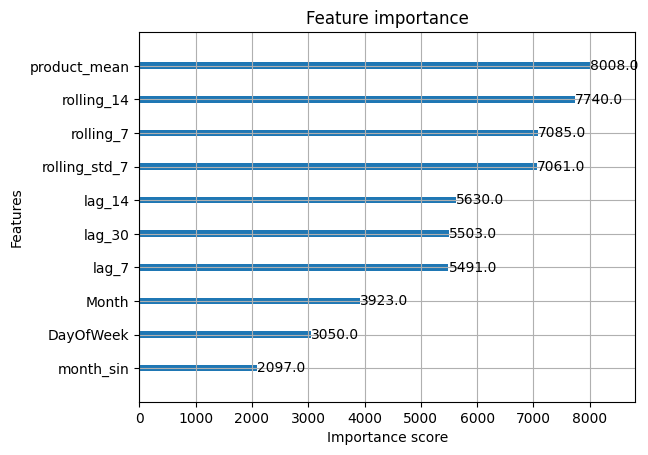

In [23]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model_xgb, max_num_features=10)
plt.show()

In [24]:
joblib.dump(model_xgb, '../models/xgb_demand_forecasting_model.pkl')

#Save the feature names
features = X_train.columns.tolist()
joblib.dump(features, '../models/forecast_features.json')

['../models/forecast_features.json']

In [ ]:
# Create a temporary dataframe with StockCodes and their predictions
# Note: We take the mean prediction per day and multiply by 7 to get 7-day demand

forecast_results = test[['StockCode']].copy()
forecast_results['Daily_Prediction'] = xgb_preds

# Aggregate by StockCode to get the 7-day total demand
predicted_7d = forecast_results.groupby('StockCode')['Daily_Prediction'].mean() * 7
predicted_7d_df = predicted_7d.reset_index()
predicted_7d_df.columns = ['StockCode', 'Predicted_7d_Demand']

predicted_7d_df.to_csv("../data/processed/predicted_7d_demand.csv", index=False)

print("File 'predicted_7d_demand.csv' created successfully!")

File 'predicted_7d_demand.csv' created successfully!
